# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install -Uq scikit-learn
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
auto_df = pd.read_csv('/datasets/autos.csv')

In [4]:
def info_about(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    display(data.duplicated().sum())
    display(data.isna().sum())
    display(data.corr())
    data.hist(figsize=(12, 12))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


4

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


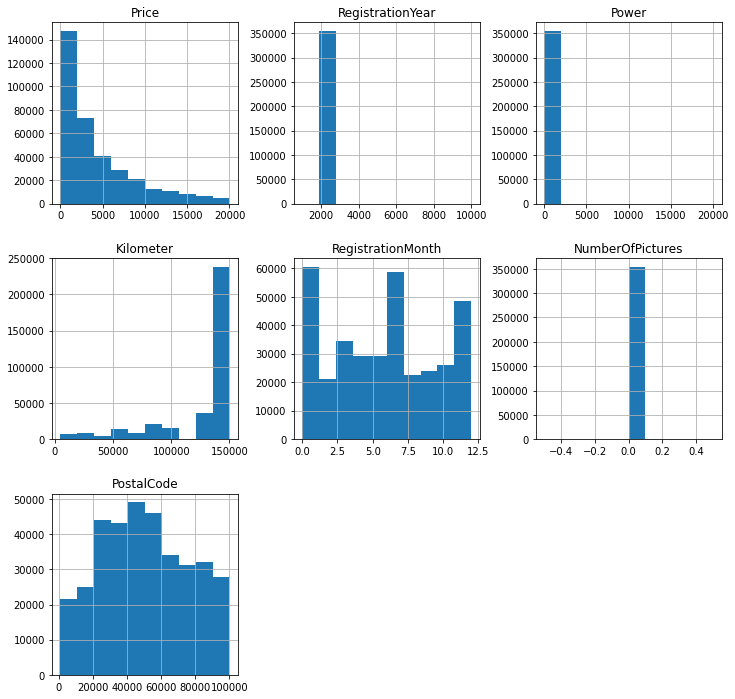

In [5]:
info_about(auto_df)

**ВЫВОДЫ:**

Price - минимальная цена 0.

RegistrationYear - есть некорректные значения.

Power - есть некорректные значения мощности двигателя.

RegistrationMonth - отсутствует месяц регистрации.

Также много пропусков в таких признаках как *VehicleType*, *Gearbox*, *Model*, *FuelType*, *Repaired*. 

Присутствуют дубликаты.

Типы данных в порядке.

## Предобработка данных

In [6]:
#переведем в змеиный регистр
auto_df.columns = auto_df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
auto_df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [7]:
auto_df.date_crawled.max()

'2016-04-07 14:36:58'

In [8]:
#удалим столбцы, которые нам не понадобятся
auto_df = auto_df.drop(['number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled'], axis=1)

In [9]:
display('Доля пропусков в vehicle_type: {:.2%}'.format(auto_df['vehicle_type'].isna().mean()),
       'Доля пропусков в gearbox: {:.2%}'.format(auto_df['gearbox'].isna().mean()),
       'Доля пропусков в model: {:.2%}'.format(auto_df['model'].isna().mean()),
       'Доля пропусков в fuel_type: {:.2%}'.format(auto_df['fuel_type'].isna().mean()),
       'Доля пропусков в not_repaired: {:.2%}'.format(auto_df['repaired'].isna().mean()))

'Доля пропусков в vehicle_type: 10.58%'

'Доля пропусков в gearbox: 5.60%'

'Доля пропусков в model: 5.56%'

'Доля пропусков в fuel_type: 9.28%'

'Доля пропусков в not_repaired: 20.08%'

In [10]:
auto_df.repaired.value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

In [11]:
#выведем столбцы с пропусками
auto_df[auto_df['vehicle_type'].isna() 
     & auto_df['fuel_type'].isna() 
     & auto_df['model'].isna()
     & auto_df['repaired'].isna()
     & auto_df['gearbox'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
353727,1,NaN,2000,NaN,0,NaN,150000,NaN,bmw,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN


In [12]:
#удалим строки так, чтобы из 5 столбцов c пропусками, удалились 3 с пропусками из этого списка чтобы сильно не терять данные
auto_df = auto_df.dropna(subset=['vehicle_type', 'fuel_type', 'model', 'repaired','gearbox'], thresh = 3)
auto_df.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN



<div class="alert alert-block alert-success">
<b>Успех:</b> Допустимое решение, выглядит резонным
</div>


In [13]:
#уникальные значения столбца fuel_type
auto_df.fuel_type.value_counts()

petrol      213687
gasoline     97814
lpg           5254
cng            561
hybrid         230
other          169
electric        86
Name: fuel_type, dtype: int64

In [14]:
#переименуем gasoline в petrol - и то и то бензин
auto_df['fuel_type'] = auto_df['fuel_type'].replace(['gasoline'],'petrol')

#заполним пропуски значением other
auto_df.fuel_type.fillna('other', inplace=True)



<div class="alert alert-block alert-success">
<b>Успех:</b> Правильное наблюдение, правда меня удивляет, что  среди категорий  нет дизеля
</div>

In [15]:
#уникальные значения в столбце vehicle_type
auto_df.vehicle_type.value_counts()

sedan          90870
small          79059
wagon          64683
bus            28570
convertible    20010
coupe          15995
suv            11896
other           3136
Name: vehicle_type, dtype: int64

In [16]:
#заменим пропуски на other
auto_df.vehicle_type.fillna('other', inplace=True)

In [17]:
#уникальные значения столбца gearbox
auto_df.gearbox.value_counts()

manual    262289
auto       65098
Name: gearbox, dtype: int64

In [18]:
#заполним пропуски значением unknown
auto_df.gearbox.fillna('unknown', inplace=True)

#в столбце model и repaired тоже заполним пропуски на unknown
auto_df.model.fillna('unknown', inplace=True)
auto_df.repaired.fillna('unknown', inplace=True)

In [19]:
#проверka
auto_df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [20]:
#уникальные значения в столбце registration_year
auto_df['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 2016, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989,
       2015, 1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1965, 1970, 1945, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961,
       1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941,
       1962, 1929, 1957, 1940, 1949, 1937, 1951, 1953, 2019, 2900, 6000,
       1400, 1950, 4000, 1948, 1952, 1200, 1932, 3700, 5000, 1942, 1935,
       1933, 1936, 6500, 1923, 1930, 1943, 1934, 1938, 9000, 1000, 1919,
       1928, 1931, 1602, 1927, 1947, 1946, 7500, 1944, 1600])

In [21]:
#так как последний год выгрузки 2016 и авто до 1900 это скорее всего аномалии, целесообразно будет укоротить период
auto_df = auto_df.loc[(auto_df['registration_year'] <= 2016) & (auto_df['registration_year'] >= 1900)]

In [22]:
#уникальные значения в столбце power
auto_df.power.value_counts()

0        27732
75       22234
60       14739
150      13922
101      12496
         ...  
584          1
15001        1
8011         1
1436         1
2172         1
Name: power, Length: 691, dtype: int64

<AxesSubplot:>

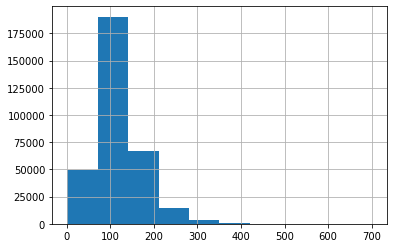

In [23]:
# удалим аномалии - скорость больше 700 лошадиных сил
auto_df = auto_df.loc[auto_df['power'] <= 700]

# заменим нули медианой 
power_med = auto_df['power'].median()

auto_df['power'] = auto_df['power'].replace(0, power_med)

auto_df.power.hist()

In [24]:
#проверим значения столбца price
auto_df.price.value_counts()

0        7565
500      5061
1500     4863
1200     4127
2500     4085
         ... 
1035        1
5385        1
15232       1
6788        1
8188        1
Name: price, Length: 3651, dtype: int64

In [25]:
#удалим нулевые значения
auto_df = auto_df.loc[auto_df['price'] > 0]

In [26]:
# проверим данные на дубликаты
auto_df.duplicated().sum()

42531

In [27]:
#удалим дубликаты(с удалением старых индексов и формированием новых)
auto_df = auto_df.drop_duplicates().reset_index(drop=True)

auto_df.duplicated().sum()

0

In [28]:
auto_df.info

<bound method DataFrame.info of         price vehicle_type  registration_year gearbox  power        model  \
0         480        other               1993  manual  105.0         golf   
1       18300        coupe               2011  manual  190.0      unknown   
2        9800          suv               2004    auto  163.0        grand   
3        1500        small               2001  manual   75.0         golf   
4        3600        small               2008  manual   69.0        fabia   
...       ...          ...                ...     ...    ...          ...   
275488   5250        other               2016    auto  150.0          159   
275489   3200        sedan               2004  manual  225.0         leon   
275490   1199  convertible               2000    auto  101.0       fortwo   
275491   9200          bus               1996  manual  102.0  transporter   
275492   3400        wagon               2002  manual  100.0         golf   

        kilometer fuel_type       brand rep

**ВЫВОДЫ:**

Избавились от признаков не влияющих на целевой.

Привели к змеиному регистру.

Избавились от выбросов, дубликатов.

Заполнены пропуски в gearbox, repaired, vehicle_type, model, fuel_type.

Обработали датафрейм.

## Обучение моделей

In [29]:
#переведем категориальные значения столбцов в количественные
data_ohe = pd.get_dummies(auto_df, drop_first=True)

In [30]:
list(data_ohe.columns.values)

['price',
 'registration_year',
 'power',
 'kilometer',
 'vehicle_type_convertible',
 'vehicle_type_coupe',
 'vehicle_type_other',
 'vehicle_type_sedan',
 'vehicle_type_small',
 'vehicle_type_suv',
 'vehicle_type_wagon',
 'gearbox_manual',
 'gearbox_unknown',
 'model_145',
 'model_147',
 'model_156',
 'model_159',
 'model_1_reihe',
 'model_1er',
 'model_200',
 'model_2_reihe',
 'model_300c',
 'model_3_reihe',
 'model_3er',
 'model_4_reihe',
 'model_500',
 'model_5_reihe',
 'model_5er',
 'model_601',
 'model_6_reihe',
 'model_6er',
 'model_7er',
 'model_80',
 'model_850',
 'model_90',
 'model_900',
 'model_9000',
 'model_911',
 'model_a1',
 'model_a2',
 'model_a3',
 'model_a4',
 'model_a5',
 'model_a6',
 'model_a8',
 'model_a_klasse',
 'model_accord',
 'model_agila',
 'model_alhambra',
 'model_almera',
 'model_altea',
 'model_amarok',
 'model_antara',
 'model_arosa',
 'model_astra',
 'model_auris',
 'model_avensis',
 'model_aveo',
 'model_aygo',
 'model_b_klasse',
 'model_b_max',
 'mode

In [31]:
numeric = list(data_ohe)
numeric.remove('price')
print(numeric)

['registration_year', 'power', 'kilometer', 'vehicle_type_convertible', 'vehicle_type_coupe', 'vehicle_type_other', 'vehicle_type_sedan', 'vehicle_type_small', 'vehicle_type_suv', 'vehicle_type_wagon', 'gearbox_manual', 'gearbox_unknown', 'model_145', 'model_147', 'model_156', 'model_159', 'model_1_reihe', 'model_1er', 'model_200', 'model_2_reihe', 'model_300c', 'model_3_reihe', 'model_3er', 'model_4_reihe', 'model_500', 'model_5_reihe', 'model_5er', 'model_601', 'model_6_reihe', 'model_6er', 'model_7er', 'model_80', 'model_850', 'model_90', 'model_900', 'model_9000', 'model_911', 'model_a1', 'model_a2', 'model_a3', 'model_a4', 'model_a5', 'model_a6', 'model_a8', 'model_a_klasse', 'model_accord', 'model_agila', 'model_alhambra', 'model_almera', 'model_altea', 'model_amarok', 'model_antara', 'model_arosa', 'model_astra', 'model_auris', 'model_avensis', 'model_aveo', 'model_aygo', 'model_b_klasse', 'model_b_max', 'model_beetle', 'model_berlingo', 'model_bora', 'model_boxster', 'model_bra

In [32]:
#Разделим признаки и целевой признак
target = data_ohe['price']
features = data_ohe.drop(['price'], axis=1) 

In [33]:
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                       target,
                                                                                       test_size=.4,
                                                                                       random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid,
                                                                                            target_valid,
                                                                                            test_size=0.5,
                                                                                            random_state=12345)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(165295, 308)
(55099, 308)
(55099, 308)


In [34]:
#масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

**LinearRegression**

In [35]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)

rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print(rmse)

2729.3328869982593
CPU times: user 10.9 s, sys: 3.42 s, total: 14.3 s
Wall time: 14.3 s


**DecisionTreeRegressor**

In [38]:
target_oe = auto_df['price']
features_oe = auto_df.drop('price', axis=1)
features_train_oe, features_valid_oe, target_train_oe, target_valid_oe = train_test_split(features_oe,
                                                                                       target_oe,
                                                                                       test_size=.4,
                                                                                       random_state=12345)
features_test_oe, features_valid_oe, target_test_oe, target_valid_oe = train_test_split(features_valid_oe,
                                                                                            target_valid_oe,
                                                                                            test_size=0.5,
                                                                                            random_state=12345)

cat_features = ['vehicle_type',
                'gearbox',
                'model',
                'fuel_type',
                'brand',
                'repaired']


oe_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

oe_encoder.fit(features_train_oe[cat_features])
features_train_oe[cat_features] = oe_encoder.transform(features_train_oe[cat_features])
features_valid_oe[cat_features] = oe_encoder.transform(features_valid_oe[cat_features])
features_test_oe[cat_features] = oe_encoder.transform(features_test_oe[cat_features])

print(features_train_oe.shape)
print(features_valid_oe.shape)
print(features_test_oe.shape)

(165295, 9)
(55099, 9)
(55099, 9)


In [39]:
%%time
for depth in range(3, 20, 3):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(features_train_oe, target_train_oe)
    predictions_valid_oe = model.predict(features_valid_oe)
    rmse = mean_squared_error(target_valid_oe, predictions_valid_oe)**0.5
    print('Глубина:', depth)
    print('RMSE DecisionTreeRegressor:', rmse)
    print('')
print()

Глубина: 3
RMSE DecisionTreeRegressor: 2975.860711614435

Глубина: 6
RMSE DecisionTreeRegressor: 2359.1077499542207

Глубина: 9
RMSE DecisionTreeRegressor: 2110.7120350252394

Глубина: 12
RMSE DecisionTreeRegressor: 1999.8431182174563

Глубина: 15
RMSE DecisionTreeRegressor: 1995.0939292209732

Глубина: 18
RMSE DecisionTreeRegressor: 2060.3477900458925


CPU times: user 1.72 s, sys: 0 ns, total: 1.72 s
Wall time: 1.74 s


Модель склонна к переобучению.

**RandomForestRegressor**

In [40]:
%%time
for est in [100, 500, 1000]:
    model = RandomForestRegressor(random_state=12345, 
                                   n_estimators=est, 
                                   max_depth=9)
    model.fit(features_train_oe, target_train_oe)
    predictions_valid_oe = model.predict(features_valid_oe)
    rmse = mean_squared_error(target_valid_oe, predictions_valid_oe)**0.5
    print('Количество:', est)
    print('RMSE RandomForestRegressor:', rmse)
    print('')
print()

Количество: 100
RMSE RandomForestRegressor: 2017.4753066855317

Количество: 500
RMSE RandomForestRegressor: 2016.7608481154716

Количество: 1000
RMSE RandomForestRegressor: 2016.283280851147


CPU times: user 4min 42s, sys: 0 ns, total: 4min 42s
Wall time: 4min 42s


Разница оказалась небольшой. Глубина предпочтительнее.

**LightGBMRegressor**

In [41]:
target_l = auto_df['price']
features_l = auto_df.drop('price', axis=1)

#переведем категориальные признаки в тип category, который требуется для LightGBM
for c in features_l.columns:
  col_type = features_l[c].dtype
  if col_type == 'object':
    features_l[c] = features_l[c].astype('category')

features_train_l, features_valid_l, target_train_l, target_valid_l = train_test_split(features_l,
                                                                                       target_l,
                                                                                       test_size=.4,
                                                                                       random_state=12345)
features_test_l, features_valid_l, target_test_l, target_valid_l = train_test_split(features_valid_l,
                                                                                            target_valid_l,
                                                                                            test_size=0.5,
                                                                                            random_state=12345)

print(features_train_l.shape)
print(features_valid_l.shape)
print(features_test_l.shape)

(165295, 9)
(55099, 9)
(55099, 9)


In [42]:
model = lgb.LGBMRegressor(random_state=12345)
model.fit(features_train_l, target_train_l)
predictions_valid_l = model.predict(features_valid_l)
rmse = mean_squared_error(target_valid_l, predictions_valid_l)**0.5
rmse

1678.9744472011037

**ВЫВОДЫ:**

Были обучены 4 модели на разных кодировках с подобранными гиперпараметрами: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LightGBMRegressor.

## Анализ моделей

**LinearRegression**

In [44]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 11.2 s, sys: 3.05 s, total: 14.2 s
Wall time: 14.2 s


LinearRegression()

In [45]:
%%time

predictions_valid = model.predict(features_valid)

CPU times: user 65.9 ms, sys: 33.3 ms, total: 99.3 ms
Wall time: 96.8 ms


**DecisionTreeRegressor**

In [46]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=9)
model.fit(features_train_oe, target_train_oe)

CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 252 ms


DecisionTreeRegressor(max_depth=9, random_state=12345)

In [47]:
%%time

predictions_valid_oe = model.predict(features_valid_oe)

CPU times: user 8.87 ms, sys: 64 µs, total: 8.94 ms
Wall time: 7.09 ms


**RandomForestRegressor**

In [48]:
%%time

model = RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=1000)
model.fit(features_train_oe, target_train_oe)

CPU times: user 2min 55s, sys: 23 ms, total: 2min 56s
Wall time: 2min 56s


RandomForestRegressor(max_depth=9, n_estimators=1000, random_state=12345)

In [49]:
%%time

predictions_valid_oe = model.predict(features_valid_oe)

CPU times: user 3.51 s, sys: 0 ns, total: 3.51 s
Wall time: 3.51 s


**LightGBMRegressor**

In [50]:
%%time
model = lgb.LGBMRegressor(random_state=12345)
model.fit(features_train_l, target_train_l)

CPU times: user 3.93 s, sys: 15.3 ms, total: 3.95 s
Wall time: 3.97 s


LGBMRegressor(random_state=12345)

In [51]:
%%time

predictions_valid_l = model.predict(features_valid_l)

CPU times: user 573 ms, sys: 0 ns, total: 573 ms
Wall time: 595 ms


In [52]:
#создадим сводную таблицу
tabledata = [["LinearRegression: обучение", "51 s", "51.3 s"],
             ["LinearRegression: предсказание", "110 ms", "99.1 ms", "2729.33"],
         ["DecisionTreeRegressor: обучение", "389 ms", "433 ms"],
         ["DecisionTreeRegressor: предсказание", "8.58 ms", "7.1 ms", "1994.49"],
         ["RandomForestRegressor: обучение", "3min 49s", "3min 50s"],
         ["RandomForestRegressor: предсказание", "4.6 s", "4.8 s", "2016.79"],
         ["LightGBMRegressor: обучение", "42 s", "42.8 s"],
         ["LightGBMRegressor: предсказание", "21.4 s", "21.3 s", "1758.41"]]
df= pd.DataFrame(tabledata, columns=["модель","CPU-times", "Wall time", "RMSE"])
df = df.set_index('модель')
df.index.names = [None]
df

,CPU-times,Wall time,RMSE
LinearRegression: обучение,51 s,51.3 s,None
LinearRegression: предсказание,110 ms,99.1 ms,2729.33
DecisionTreeRegressor: обучение,389 ms,433 ms,None
DecisionTreeRegressor: предсказание,8.58 ms,7.1 ms,1994.49
RandomForestRegressor: обучение,3min 49s,3min 50s,None
RandomForestRegressor: предсказание,4.6 s,4.8 s,2016.79
LightGBMRegressor: обучение,42 s,42.8 s,None
LightGBMRegressor: предсказание,21.4 s,21.3 s,1758.41


In [53]:
#используем тестовую выборку на лучшей модели
predictions_test = model.predict(features_test_l)
rmse = mean_squared_error(target_test_l, predictions_test)**0.5
rmse

1658.8962162137088

Самое длительное обучение происходит у модели RandomForestRegressor - почти 4 минуты.

Самое быстрое же обучение у модели DecisionTreeRegressor 389 мс.

Модель LightGBMRegressor имеет оптимальную скорость обучения и предсказания и наименьшую RSME, а именно 1758.41.

Используя тестовую выборку на лучшей модели получили значение RMSE = 1658.89.

## Общий вывод

Нами был изучен, обработан и подготовлен к обучению моделей датасет сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

В ходе исследования были выполнены следующие действия:

- Избавились от признаков не влияющих на целевой.

- Привели к змеиному регистру.

- Избавились от выбросов, дубликатов.

- Заполнены пропуски в gearbox, repaired, vehicle_type, model, fuel_type.

Для модели LinearRegression перевели категориальные значения столбцов в количественные. Для моделей DecisionTreeRegressor и RandomForestRegressor применили порядковое кодирование. Мы обучили разные модели, подобрали гиперпараметры для них и обнаружили, что модель LightGBM с гиперпараметрами n_estimators: 1000, num_leaves: 60 дает наименьшее значение rmse: 1758.41.


Самое длительное обучение происходит у модели RandomForestRegressor - почти 4 минуты.

Самое быстрое же обучение у модели DecisionTreeRegressor 389 мс.

Модель LightGBMRegressor имеет оптимальную скорость обучения и предсказания и наименьшую RSME на тестовой выборке, а именно 1758.41.

Используя тестовую выборку на лучшей модели получили значение RMSE = 1658.89.


**Рекомендации заказчику относительно его требований - модель LightGBMRegressor, самые оптимальные характеристики именно у нее.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей